sample width: 2
channel num: 4
frames: 480704
multi_data.shape: (4, 480704)
(4, 257, 1879)


/tmp/ipykernel_1239/2750385847.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
  P_DS[set_num-1][i] = np.mean(aHRa / aHa)


Text(0.5, 0, 'Time[frame]')

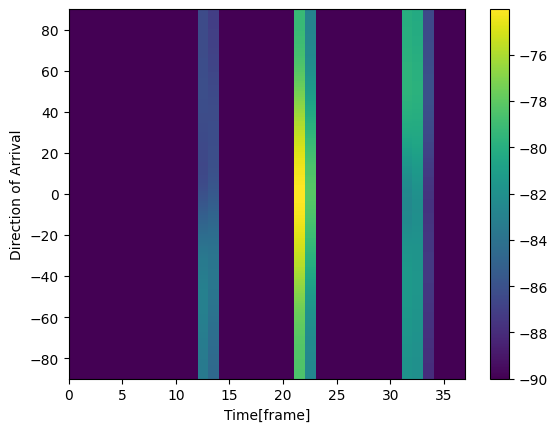

In [2]:
import wave as wave
import numpy as np
import scipy.signal as sp
import matplotlib.pyplot as plt

def calc_array_manifold_vector(mic_alignments, theta, n_mic, n_bin, fs, N):
    """
    a: i x n_mic x 1 x n_bin
       方向数 x マイク数 x 1 x 周波数ビン数
    """
    a = np.zeros((theta.shape[0], n_mic, 1, n_bin), dtype=np.complex64)
    for i, th in enumerate(theta):
        th = np.radians(th)
        for k in range(n_bin):
            fk = fs*k/N
            for m in range(n_mic):
                delay = mic_alignments[m][0]*np.sin(th)/c
                a[i,m,0,k] = np.exp(-1j*2*np.pi*fk*delay)
    return a

def load_onefile(file_name):
    """
    return M x frames ndarray
    """
    wav = wave.open(file_name)
    print("sample width:", wav.getsampwidth())
    print("channel num:", wav.getnchannels())
    print("frames:", wav.getnframes())

    M = wav.getnchannels()

    data = wav.readframes(wav.getnframes())
    data = np.frombuffer(data, dtype=np.int16)
    data = data/np.iinfo(np.int16).max

    multi_data = data.reshape(-1, M)
    multi_data = np.transpose(multi_data)
    print("multi_data.shape:", multi_data.shape)

    wav.close()

    return multi_data

dir_name = "mic/"
png_name = "DSBF.png"
n_mic  = 4
n_src  = 1
N      = 512
window = "hann"
d      = 0.01
c      = 340
freq_l = 800
freq_h = 3000

mic_alignments = np.array(
    [
        [-0.112, 0.0, 0.0],
        [-0.075, 0.0, 0.0],
        [-0.035, 0.0, 0.0],
        [0.113, 0.0, 0.0],
    ]
)

fs = 16000

# 周波数ビンに変換
k_l = int(freq_l/(fs/N))
k_h = int(freq_h/(fs/N))

file_name = "sep_0.wav"
audio = load_onefile(file_name)

f, t, X = sp.stft(audio, fs, window=window, nperseg=N)
n_bin = X.shape[1]
print(X.shape)

frame_set = 50
set_num = 1

theta = np.linspace(-90.0, 90.0, 181)
P_DS = np.zeros((X.shape[2] // 50, theta.shape[0]))
a = calc_array_manifold_vector(mic_alignments, theta, n_mic, n_bin, fs, N)

while set_num * frame_set < X.shape[2]:
    X_trimed = X[:, :, (set_num-1)*frame_set:set_num*frame_set]
    XH = np.conjugate(X_trimed)
    XXH = np.einsum("mki,nki->mnki", X_trimed, XH)
    R = np.mean(XXH, axis=3)

    for i, th in enumerate(theta):
        aH = np.conjugate(a[i])
        aHR = np.einsum("mik,mek->ek", aH, R)
        aHRa = np.einsum("ek,eik->k", aHR, a[i])
        aHa = np.einsum("mik,mik->k", aH, a[i])
        aHa = abs(aHa) * abs(aHa)
        P_DS[set_num-1][i] = np.mean(aHRa / aHa)
    
    set_num = set_num + 1

# 方向数 x 周波数インデックス数 x 時間軸　の3次元

P_DS = 10*np.log10(P_DS)
P_DS = P_DS.transpose()
color_min = -90
color_max = np.max(P_DS)
plt.imshow(P_DS, interpolation="nearest", aspect="auto", extent=[0, P_DS.shape[1], -90, 90], vmin=color_min, vmax=color_max)
plt.colorbar()
plt.ylabel("Direction of Arrival")
plt.xlabel("Time[frame]")